## Statistical bias

In [1]:
import os
import torch
import random
import string
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_experiment


def get_encodings(model_dict, idxs, task_num=2):
    try:
        data_path = model_dict['data_path']
    except KeyError:
        data_path = None
    dataset, model, config = load_experiment(model_dict['config'], model_dict['ckpt'], data_path=data_path)
    X, y = dataset[idxs]
    y = y.detach().numpy()
    if task_num=='BottomBias':
        condition = y[:,1] > 6
    elif task_num=='AlignBias':
        condition = y[:,0] == y[:,1]

    y = np.where(condition, 1, 0)
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    model.to(device)
    model.eval()
    mu, logvar = model.encode(X.to(device))
    #Z = model.reparameterize(mu, logvar).detach().numpy()
    mu = mu.cpu().detach().numpy()
    # logvar = logvar.detach().numpy()
    #Z = np.concatenate([mu, logvar], axis=1)
    return mu, y

def compute_dissimilarity_m(idxs, enc, **kwargs):
    l = enc.shape[1]
    df = pd.DataFrame(enc, columns=[f'z{i}' for i in range(l)])
    df['idx'] = idxs
    df.set_index('idx', inplace=True)
    return .5 * (1 - df.T.corr())

def compute_dissimilarity_m1(idxs, enc, **kwargs):
    return pd.DataFrame(data=pairwise_distances(enc), columns=idxs, index=idxs)


def get_embeddings(diss_m, n_components=2, **kwargs):
    embedding = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, **kwargs)
    out_ = embedding.fit_transform(diss_m)
    return out_

def get_idx2label(row):
    return f'{row[169]},{row[170]}' 

#### select images

In [2]:
data = pd.read_csv('data/mazes_200k_2corridors_13x13.csv', header=None)
data = data.iloc[180_000:]
data['diff'] = data.iloc[:,169] - data.iloc[:,170]
#data = data.sort_values(by=['diff'])
n_imgs = 1500
idxs = data.sample(n_imgs).index
selected_idxs = [
    185_044, #0,12
    199_915, #2,10
    194_158, #4,8
    189_971, #6,6
    190_889, #8,4
    187_869, #10,2
    193_280, #12,0
    191126, #0,0
    185419, #2,2
    198997, #10,10
    197722, #12,12
    195734, #2,4
    194955, #4,2
    198524, #8,10
    185387, #10,8
    198185, #6,12
    192299, #6,0
    191412, #12,6
    188274, #0,6
    #185250, #6,4
    #196000, #6,8
    190549, #1,5
    190769, #5,1
    186536, #7,11
    188431, #11,7
]
idxs = idxs.union(selected_idxs)
data = data.loc[idxs].sort_values(by=['diff'])
idxs = data.index
idx2label = data.apply(get_idx2label, axis=1).to_dict()

In [3]:
reidxs = {idx: i for i, idx in enumerate(idxs)}
reidx2label = {reidxs[idx]: idx2label[idx] for idx in idxs}
selected_reidxs = [reidxs[selected_idx] for selected_idx in selected_idxs]


# idx to be annotated in the scatter plot
idx_toLabel = []#list(range(0, n_imgs, 50))
idx_toLabel.extend(selected_reidxs)

In [4]:
#data[(data.iloc[:,169] == 11)&(data.iloc[:,170] == 7)]

#### select models

In [5]:
models = {

    'BottomBias':{
        'base_high': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml', 
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_10/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
    },
    
    'AlignBias':{
        'base_high': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml', 
            #'data_path': 'data/mazes_85k_2corridors_AlignedBias3000vs300.csv',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_10/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            #'data_path': 'data/mazes_85k_2corridors_AlignedBias3000vs300.csv',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
    },
}

#### plot

In [23]:
def plot_diss_m(diss_m, title, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    else:
        fig = None
    #ax.set_title(title)
    sns.heatmap(diss_m, ax=ax, annot=False, cmap='summer_r', xticklabels=False, yticklabels=False, **kwargs)
    return fig, ax

def plot_embeddings(emb, y, idx_toLabel, reidx2label, title, palette='Pastel2', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    else:
        fig = None
    #ax.set_title(title)
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=y, palette=palette, ax=ax, s=120)
    #ax.set_xticks([])
    #ax.set_yticks([])
    eps = 0.01
    for i in idx_toLabel:
        txt = reidx2label[i]
        ax.annotate(txt, (emb[i,0]+eps, emb[i,1]), size=17)
        ax.scatter(x=emb[i,0], y=emb[i,1], facecolor='none', edgecolor='black', s=120)
    return fig, ax

def plot_embeddings_3d(emb, y, idx_toLabel, reidx2label, title, ax):
    fig = None

    ax.scatter(emb[:,0], emb[:,1], emb[:,2], c=y, s=50, cmap='Pastel2')
    for i in idx_toLabel:
        txt = reidx2label[i]
        ax.text(emb[i,0], emb[i,1], emb[i,2], txt, size=17)
        ax.scatter(emb[i,0], emb[i,1], emb[i,2], facecolor='none', edgecolor='black', s=50)
        
    return fig, ax

def save_fig(in_fig, out_file, **kwargs):
    in_fig.savefig(out_file, bbox_inches='tight', pad_inches=0.1, **kwargs)
    
def get_fig_name(parent_dir, model_name, plot_type):
    """
    parent_dir : eucl_diss | corr_diss
    plot_type : dissM | emb
    """
    _, _, task, diss_metric = parent_dir.split('/')
    model_type, capacity = model_name.split('_')
    filename = f'{diss_metric[:4]}_t{task[-1]}_{model_type}_{capacity}_{plot_type}.png'
    out_dir = os.path.join(parent_dir, model_type, capacity)
    os.makedirs(out_dir, exist_ok=True)
    return os.path.join(out_dir, filename)

### IMG FOR PAPER

/tmp/ipykernel_1281077/3645978417.py:42: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



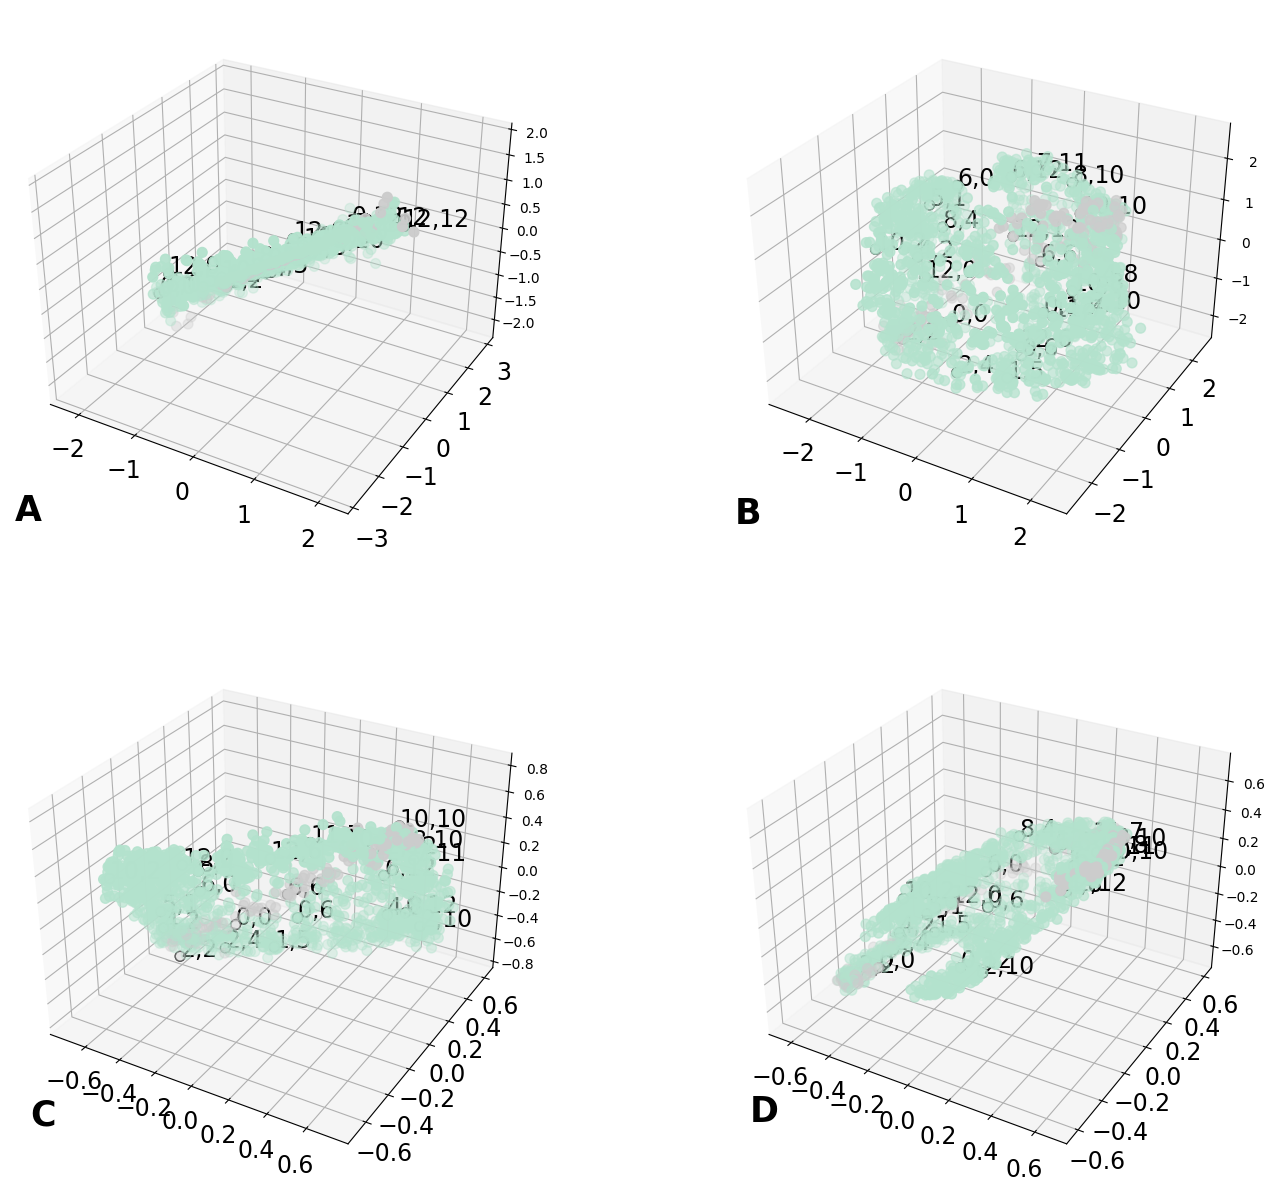

In [24]:
np.random.seed(42)
random.seed(42)
    
task = 'AlignBias'

fig, axs = plt.subplots(2, 2, figsize=(17, 15), subplot_kw={'projection': '3d'})
axs = axs.flatten()
i = 0

for model_name, model_dict in models[task].items():
    
    Z, y = get_encodings(model_dict, idxs, task_num=task)
    diss_m = compute_dissimilarity_m1(idxs, Z)
    emb = get_embeddings(diss_m, n_init=1, n_components=3)

    #fig, ax = plot_diss_m(diss_m= diss_m, title=f'{model_name}', vmin=0, vmax=6)

    if i in []:
        new_emb = emb.copy()
        new_emb[:,0] = emb[:,1]
        new_emb[:,1] = - emb[:,0]
        emb = new_emb

    # set 3d projection for ax
    axs[i].set_proj_type('persp', focal_length=0.5)  
    _, _ = plot_embeddings_3d(emb=emb, y=y, idx_toLabel=idx_toLabel, reidx2label=reidx2label, title=f'{model_name}', ax=axs[i])


    # increase font size for labels
    for item in axs[i].get_yticklabels() + axs[i].get_xticklabels():# + axs[i].get_legend().get_texts():
        item.set_fontsize(17)

    #write a bold letter on every plot
    axs[i].text(0, 1.01, 1, string.ascii_uppercase[i], transform=axs[i].transAxes, size=25, weight='bold')


    handles, labels = axs[0].get_legend_handles_labels()

    i += 1


fig.tight_layout()
fig.show()


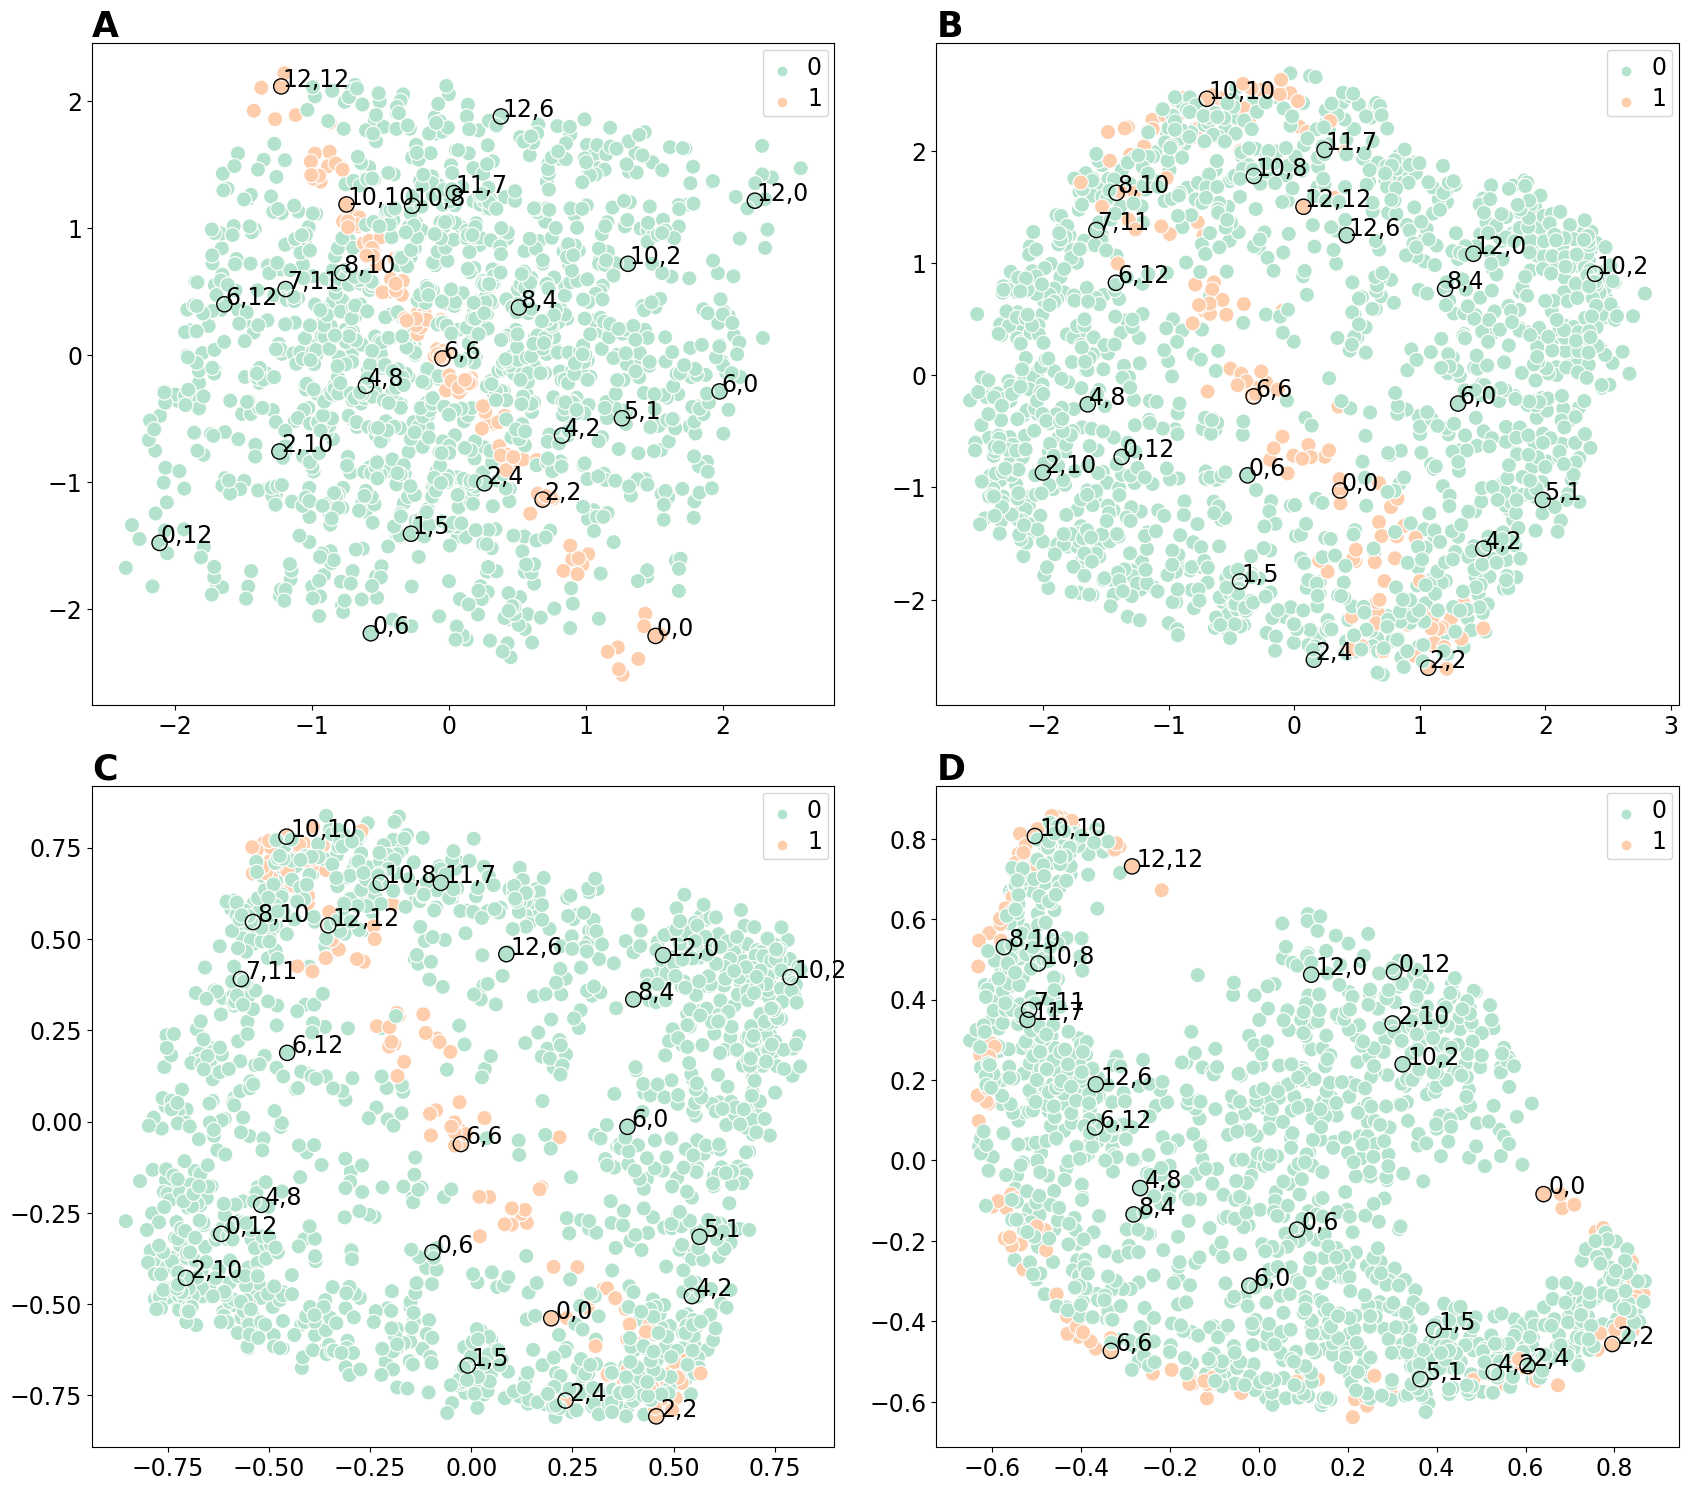

In [16]:
np.random.seed(42)
random.seed(42)
    
task = 'AlignBias'

fig, axs = plt.subplots(2, 2, figsize=(17, 15))
axs = axs.flatten()
i = 0

for model_name, model_dict in models[task].items():
    
    Z, y = get_encodings(model_dict, idxs, task_num=task)
    diss_m = compute_dissimilarity_m1(idxs, Z)
    emb = get_embeddings(diss_m, n_init=1)

    #fig, ax = plot_diss_m(diss_m= diss_m, title=f'{model_name}', vmin=0, vmax=6)

    if i in []:
        new_emb = emb.copy()
        new_emb[:,0] = emb[:,1]
        new_emb[:,1] = - emb[:,0]
        emb = new_emb

    _, _ = plot_embeddings(emb=emb, y=y, idx_toLabel=idx_toLabel, reidx2label=reidx2label, title=f'{model_name}', ax=axs[i])


    # increase font size for labels
    for item in axs[i].get_yticklabels() + axs[i].get_xticklabels() + axs[i].get_legend().get_texts():
        item.set_fontsize(17)

    #write a bold letter on every plot
    axs[i].text(0, 1.01, string.ascii_uppercase[i], transform=axs[i].transAxes, size=25, weight='bold')


    handles, labels = axs[0].get_legend_handles_labels()

    i += 1


fig.tight_layout()
fig.show()


In [ ]:
fig.savefig(f"imgs/for_paper/stat_bias/eucl_emb_{task}.pdf", format='pdf')

### 3D images

In [11]:
#plot 3d points using plotly
import plotly.graph_objects as go

np.random.seed(42)
random.seed(42)

task = 'AlignBias'
#parent_dir = f'imgs/clf_bias/{task}/corr_diss'

model_name = 'distorted_low'
model_dict = models[task][model_name]

Z, y = get_encodings(model_dict, idxs, task_num=task)
diss_m = compute_dissimilarity_m1(idxs, Z)
emb = get_embeddings(diss_m, n_components=3, n_init=1)

In [12]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Scatter3d(
    x=emb[:,0],
    y=emb[:,1],
    z=emb[:,2],
    mode='markers',
    text=list(reidx2label.values()),
    marker=dict(
        size=4,
        color=y,                # set color to an array/list of desired values
        colorscale=px.colors.qualitative.Vivid_r,
        line=dict(
                color='lightgrey',
                width=0.01,
        ),
        opacity=0.8
    )
)])
# increase fig sizze
fig.update_layout(
    width=700,
    height=700,
)
fig.show()